In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [110]:
import matplotlib.pyplot as plt
from itertools import product

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


In [18]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# One-hot embarkment point

In [19]:
train['Sex'] = train['Sex'].map({'male' : 0, 'female' : 1})
train = pd.get_dummies(train, columns = ['Embarked'])

train['Embarked_C'] = train['Embarked_C'].map({False : 0, True : 1})
train['Embarked_Q'] = train['Embarked_Q'].map({False : 0, True : 1})
train['Embarked_S'] = train['Embarked_S'].map({False : 0, True : 1})

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,0,1


# Group families into same cabin

In [20]:
train = train.sort_values(['Name', 'Cabin'], ascending = False).reset_index()

In [22]:
i = 0
while(i < len(train)-1):
    last_name = train.loc[i, 'Name'].split(",")[0]
    next_last_name = train.loc[i+1, 'Name'].split(",")[0]
    
    while(last_name == next_last_name):
        train.loc[i+1, 'Cabin'] = train.loc[i, 'Cabin']
        i += 1
        last_name = train.loc[i, 'Name'].split(",")[0]
        next_last_name = train.loc[i+1, 'Name'].split(",")[0]
    i += 1

# One-hot cabin decks

In [23]:
train['Cabin_exists'] = train['Cabin'].notna()
train['Cabin_exists'] = train['Cabin_exists'].map({True: 1, False: 0})

In [24]:
train['Cabin'] = train['Cabin'].str.slice(0, 1)
train = pd.get_dummies(train, columns = ['Cabin'], dummy_na = False)

In [25]:
for i in range(15, len(train.columns)):
    train.iloc[:, i] = train.iloc[:, i].map({False : 0, True : 1})

/tmp/ipykernel_33/1038473942.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0
1      0
2      0
3      0
4      0
      ..
886    0
887    0
888    0
889    0
890    0
Name: Cabin_A, Length: 891, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train.iloc[:, i] = train.iloc[:, i].map({False : 0, True : 1})
/tmp/ipykernel_33/1038473942.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0      0
1      0
2      0
3      0
4      0
      ..
886    0
887    0
888    0
889    0
890    0
Name: Cabin_B, Length: 891, dtype: int64' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  train.iloc[:, i] = train.iloc[:, i].map({False : 0, True : 1})
/tmp/ipykernel_33/1038473942.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will

# Fill NaN's in Age with mean age

In [26]:
train.columns

Index(['index', 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age',
       'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Cabin_exists', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T'],
      dtype='object')

In [27]:
mean_age = train['Age'].mean()
train['Age'] = train['Age'].fillna(mean_age)

In [28]:
train.head()

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,...,Embarked_S,Cabin_exists,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,868,869,0,3,"van Melkebeke, Mr. Philemon",0,29.699118,0,0,345777,...,1,0,0,0,0,0,0,0,0,0
1,153,154,0,3,"van Billiard, Mr. Austin Blyler",0,40.500000,0,2,A/5. 851,...,1,0,0,0,0,0,0,0,0,0
2,361,362,0,2,"del Carlo, Mr. Sebastiano",0,29.000000,1,0,SC/PARIS 2167,...,0,0,0,0,0,0,0,0,0,0
3,282,283,0,3,"de Pelsmaeker, Mr. Alfons",0,16.000000,0,0,345778,...,1,0,0,0,0,0,0,0,0,0
4,286,287,1,3,"de Mulder, Mr. Theodore",0,30.000000,0,0,345774,...,1,0,0,0,0,0,0,0,0,0


# Prepare train/test data

In [29]:
train_df = pd.DataFrame(train)
train_df = train_df.drop(['PassengerId', 'Name', 'index', 'Cabin_exists', 'Ticket'], axis = 1)

In [77]:
train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0,3,0,29.699118,0,0,9.5000,0,0,1,0,0,0,0,0,0,0,0
1,0,3,0,40.500000,0,2,14.5000,0,0,1,0,0,0,0,0,0,0,0
2,0,2,0,29.000000,1,0,27.7208,1,0,0,0,0,0,0,0,0,0,0
3,0,3,0,16.000000,0,0,9.5000,0,0,1,0,0,0,0,0,0,0,0
4,1,3,0,30.000000,0,0,9.5000,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,2,1,28.000000,1,0,24.0000,1,0,0,0,0,0,0,0,0,0,0
887,0,2,0,30.000000,1,0,24.0000,1,0,0,0,0,0,0,0,0,0,0
888,1,3,1,35.000000,1,1,20.2500,0,0,1,0,0,0,0,0,0,0,0
889,0,3,0,16.000000,1,1,20.2500,0,0,1,0,0,0,0,0,0,0,0


In [81]:
# Standardize some columns
train_df['Pclass'] = (train_df['Pclass']-train_df['Pclass'].mean())/train_df['Pclass'].std()
train_df['Age'] = (train_df['Age']-train_df['Age'].mean())/train_df['Age'].std()
train_df['Fare'] = (train_df['Fare']-train_df['Fare'].mean())/train_df['Fare'].std()
train_df['SibSp'] = (train_df['SibSp']-train_df['SibSp'].mean())/train_df['SibSp'].std()

In [83]:
y = train_df['Survived']
X = train_df.drop(['Survived'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

# Logistic Regression

In [84]:
logis = LogisticRegression()
logis.fit(X_train, y_train)

logis_preds = logis.predict(X_test)

report = classification_report(y_test, logis_preds)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       111
           1       0.74      0.72      0.73        68

    accuracy                           0.80       179
   macro avg       0.79      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



# SVM

In [85]:
svm = SVC(kernel = 'linear')
svm.fit(X_train, y_train)

svm_preds = svm.predict(X_test)

report = classification_report(y_test, svm_preds)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       111
           1       0.69      0.66      0.68        68

    accuracy                           0.76       179
   macro avg       0.75      0.74      0.74       179
weighted avg       0.76      0.76      0.76       179



# Random Forest


In [86]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

report = classification_report(y_test, rf_preds)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       111
           1       0.71      0.74      0.72        68

    accuracy                           0.79       179
   macro avg       0.77      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



# XGboost

In [88]:
xgb = XGBClassifier(gamma = 1, max_depth = 3, subsample = 0.9, reg_lambda = 0, reg_alpha = 0)
xgb.fit(X_train, y_train)

xgb_preds = xgb.predict(X_test)

accuracy = accuracy_score(y_test, xgb_preds)
print(accuracy)

report = classification_report(y_test, xgb_preds)
print(report)

0.8156424581005587
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       111
           1       0.78      0.72      0.75        68

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



# XGB Tuning

In [63]:
param_grid = {
    'gamma' : [i/2 for i in range(5)], 
    'max_depth' : [i for i in range(2,8)],
    'subsample' : [i/10 for i in range(0, 11)],
    'reg_lambda' : [i/2 for i in range(0,10)],
    'reg_alpha' : [i/2 for i in range(0,10)]
}

In [64]:
xgb_tune = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_tune, param_grid=param_grid, 
                           scoring='accuracy', cv=5, 
                           verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 33000 candidates, totalling 165000 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.0, 0.5, 1.0, 1.5, 2.0],
                         'max_depth': [2, 3, 4, 5, 6, 7],
                         'reg_alpha': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,
                                       4.0, 4.5],
                         'reg_lambda': [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,
                                        4.0, 4.5],
                         'subsample': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                       0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=1)

In [87]:
best_model = grid_search.best_estimator_
xgb_tune_pred = best_model.predict(X_test)

report = classification_report(y_test, xgb_tune_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.03      0.05       111
           1       0.39      1.00      0.56        68

    accuracy                           0.40       179
   macro avg       0.69      0.51      0.31       179
weighted avg       0.77      0.40      0.24       179



In [66]:
params_to_get = ['gamma', 'max_depth', 'subsample', 'reg_alpha', 'reg_lambda']
model_params = best_model.get_params()

for p in params_to_get:
    print(p + ": " + str(model_params[p]))
    print()

gamma: 1.0

max_depth: 3

subsample: 0.9

reg_alpha: 0.0

reg_lambda: 0.0



# Neural Nets


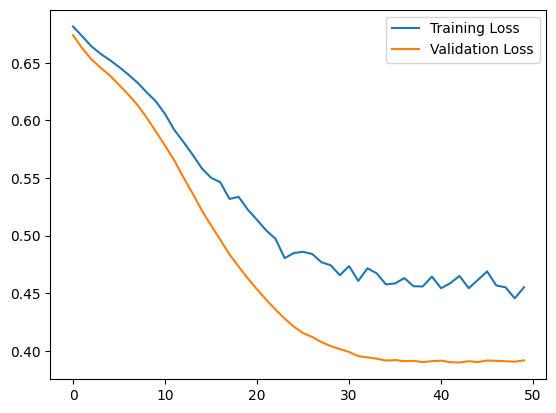

In [103]:
# Simple dense NN
simple_dense = Sequential()
simple_dense.add(Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
simple_dense.add(Dropout(0.2))
simple_dense.add(Dense(32, activation = 'relu'))
simple_dense.add(Dense(1, activation = 'sigmoid'))

simple_dense.compile(optimizer=Adam(),
              loss=BinaryCrossentropy(),
              metrics=['accuracy'])

history = simple_dense.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose = 0)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [104]:
dense_preds = simple_dense.predict(X_test, verbose = 0)
dense_preds = np.where(dense_preds < 0.5, 0, 1)

report = classification_report(y_test, dense_preds)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.87      0.84       111
           1       0.76      0.65      0.70        68

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179



# Tuning Dense/Dropout NN

In [115]:
NN_grid = {
    'dropout_rate' : [i/20 for i in range(11)],
    'num_layers' : [i for i in range(2, 6)],
    'nodes_per_layer' : [8, 16, 32, 64, 128]
}

In [118]:
# inputs -
#   input_shape: tuple - shape of input layer
#   dropout_rate: int - dropout_rate of dropout layers
#   num_layers: int - number of layers (not including output)
#   nodes_per_layer: number of nodes in each layer (not including output)

def create_model(input_shape, dropout_rate, num_layers, nodes_per_layer):
    model = Sequential()
    
    for i in range(num_layers):
        if (i == 0):
            model.add(Dense(nodes_per_layer, input_shape = input_shape, activation = 'relu'))
        else:
            model.add(Dense(nodes_per_layer, activation = 'relu'))
            model.add(Dropout(dropout_rate))
            
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='BinaryCrossentropy',
                  metrics=['accuracy'])
    return model

In [125]:
best_accuracy = 0
best_params = None
best_model = None

for dr, n_layers, nodes in product(NN_grid['dropout_rate'], NN_grid['num_layers'], NN_grid['nodes_per_layer']):
    print(str(dr) + " " + str(n_layers) + " " + str(nodes))
    
    NN = create_model((X_train.shape[1],), dr, n_layers, nodes)
    
    history = NN.fit(X_train, y_train, epochs = 100, validation_split = 0.2, verbose = 0)
    _, accuracy = NN.evaluate(X_test, y_test, verbose=0)
    
    print(accuracy)
    if (accuracy > best_accuracy):
        best_accuracy = accuracy
        best_params = (dr, n_layers, nodes)
        best_model = NN

0.0 2 8
0.7877094745635986
0.0 2 16
0.8044692873954773
0.0 2 32
0.8156424760818481
0.0 2 64
0.8100558519363403
0.0 2 128
0.8156424760818481
0.0 3 8
0.8156424760818481
0.0 3 16
0.8044692873954773
0.0 3 32
0.7932960987091064
0.0 3 64
0.8212290406227112
0.0 3 128
0.8100558519363403
0.0 4 8
0.7765362858772278
0.0 4 16
0.7821229100227356
0.0 4 32
0.7988826632499695
0.0 4 64
0.8156424760818481
0.0 4 128
0.8044692873954773
0.0 5 8
0.8212290406227112
0.0 5 16
0.7932960987091064
0.0 5 32
0.8156424760818481
0.0 5 64


KeyboardInterrupt: 

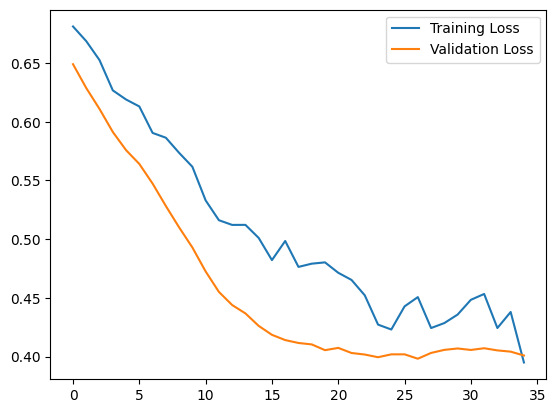

In [131]:
NN_best = Sequential()
NN_best.add(Dense(32, activation = 'relu'))
NN_best.add(Dense(32, activation = 'relu'))
NN_best.add(Dropout(0.5))
NN_best.add(Dense(32, activation = 'relu'))
NN_best.add(Dropout(0.5))
NN_best.add(Dense(1, activation = 'sigmoid'))

NN_best.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='BinaryCrossentropy',
                  metrics=['accuracy'])

history = NN_best.fit(X_train, y_train, validation_split = 0.2, epochs = 35, verbose = 0)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [133]:
NN_best_preds = NN_best.predict(X_test)
NN_best_preds = np.where(NN_best_preds < 0.5, 0, 1)

report = classification_report(y_test, NN_best_preds)
print(report)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       111
           1       0.77      0.71      0.74        68

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179

